In [1]:
#Load Packages
import cmasher           as cmr
import cartopy.crs       as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy             as np
import os
import pandas            as pd 
import regionmask        as rm
import warnings
import xarray            as xr
print("Packages Loaded")

Packages Loaded


In [2]:
#Set Working Directory
wd = '/Users/chrishancock/Library/CloudStorage/OneDrive-NorthernArizonaUniversity/Research/Manuscript/HoloceneHydroclimate/HoloceneHydroclimate'
os.chdir(wd)
print('Working wirectory set to: '+wd)

Working wirectory set to: /Users/chrishancock/Library/CloudStorage/OneDrive-NorthernArizonaUniversity/Research/Manuscript/HoloceneHydroclimate/HoloceneHydroclimate


In [3]:
#Load Model Data TraCE & HadCM
modelData = {}
for model in ['hadcm','trace','cmip6']:
    modelData[model] = {}
    for szn in ['ANN','JJA','DJF']:
        if model == 'cmip6': end = '.nc'
        else: end =  '_regrid.nc'
        handle = xr.open_dataset('Data/Model/'+model+'/'+model+'_'+szn+end,decode_times=False)
        modelData[model][szn] = handle
        handle.close()    
    print(model+" "+str(sorted([i for i in modelData[model][szn].data_vars]))+' loaded')
    
#Define ipcc region data
refReg     = rm.defined_regions.ar6.all
refRegLand = rm.defined_regions.ar6.land

hadcm ['evp_regrid', 'p-e_regrid', 'pre_regrid', 'tas_regrid'] loaded
trace ['evp_regrid', 'p-e_regrid', 'pre_regrid', 'tas_regrid'] loaded
cmip6 ['evp', 'p-e', 'pre', 'tas'] loaded


In [4]:
#Plot Agreement Settings

#Model Data to Plot
szn       = 'ANN'
variables = ['pre','tas']

#Proxy Settings
n_thresh = 4 #minimum number of proxy records needed to plot on map

#True/False to save/not save
save = True 

#Plot Settings
plt.rcParams['font.family'   ] = 'Times New Roman'
plt.rcParams['axes.facecolor'] ='white'
plt.rcParams['axes.linewidth'] = 0.8; 
plt.rcParams['axes.edgecolor'] = 'k'

figSize = [6.5,4] # x,y in
orient = 'h' #vertical (v) or horizontal (h)

#Print summary
if save: print("Settings chosen to save "+szn+" "+str(variables))
else:    print("Settings chosen to plot "+szn+" "+str(variables))

Settings chosen to save ANN ['pre', 'tas']


In [5]:
#Calculate Model Percents
modelVals = {}
for season in ['ANN','DJF','JJA']:
    modelVals[season] = {}
    for var in variables:
        modelVals[season][var]= {}
        modelAnom     = modelData['cmip6'][season][var]
        for model in ['hadcm','trace']:       
            vals = modelData[model][season]
            vals = vals.rename({var+'_regrid':var})
            vals = vals[var].groupby_bins('age',[0,1000,5500,6500]).mean(dim="age")
            vals = vals[2,:,:]-vals[0,:,:]
            vals = vals.expand_dims("model").assign_coords(model=("model", [model]))
            modelAnom = xr.concat([modelAnom,  vals], dim="model")
        modelVals[season][var]['modelAnom']  = modelAnom
        modelN = len(modelVals[season][var]['modelAnom'].model)
        modelVals[season][var]['modelSign']  = np.sum(np.sign(modelAnom),axis=0) 
        modelVals[season][var]['modelSign%'] = 100*(modelVals[season][var]['modelSign']/modelN)

In [6]:
#%%
#Calculate Proxy Percents
proxyData = {}
for var in variables:
    if var == 'tas': proxy = pd.read_csv('Data/proxy/proxyMetaData_T.csv')
    else:            proxy = pd.read_csv('Data/proxy/proxyMetaData_HC.csv')
    #Only use one seasonality per site
    proxy=proxy.loc[proxy.season.str.lower().isin(['annual','summer','winter','summeronly','winteronly',np.nan])] 
    #Empty vectors to save data
    #Abreviation, % wet proxy, % wet models at model lcoation, average anom at proxy location, n of locations, lats, lons, does Pcts=PseudoPct
    Regs, Pcts, PseudoPct, PseduoAvg, n, lats, lons, agreeByProxylocation = [],[],[],[],[],[],[],[]
    #
    for reg in np.unique(proxy['ipccReg']): 
        #
        #Filter proxy data for region. Only use if enough data points
        regData = proxy.loc[proxy['ipccReg'] == reg]
        #Exclude marine records for Hydro. These often refelct terrestrial processes and there might my negative covar over oceans
        #if var != 'tas': regData = regData.loc[regData['archive'] != 'MarineSediment'] 
        if np.shape(regData)[0] < 4: continue
        #Calculate midHolocene anomalies
        direction = np.where(regData['direction'] == 'negative',-1,1)
        regProxyAnoms = (regData['ka_6']-regData['ka_0.5'])*direction
        regProxyAnoms = regProxyAnoms[regProxyAnoms.notnull()]
        #Only use if pass theshold
        if sum(~np.isnan(regProxyAnoms)) < 4: continue
        #Calculate pseudoproxy
        pseudoVal,agreeByLoc  = [],[]
        #for prox in (regData['ka_6']-regData['ka_0.5']).index:
        for i in regProxyAnoms.index:
            #Get geographic location of proxy
            proxyLon = regData.longitude[i]
            proxyLat = regData.latitude[i]
            if proxyLon < 0: proxyLon = 360 + proxyLon
            proxySzn = str(regData.season[i])
            #Get correct season interp of proxy
            if proxyLat < 0:
                if    proxySzn[:3].lower() == 'sum': proxySzn='DJF'
                elif  proxySzn[:3].lower() == 'win': proxySzn='JJA'
                else: proxySzn = 'ANN'
            else:
                if    proxySzn[:3].lower() == 'sum': proxySzn='JJA'
                elif  proxySzn[:3].lower() == 'win': proxySzn='DJF'
                else: proxySzn = 'ANN'
            #Climate variable to use
            if var =='tas': 
                proxyVar = 'tas'
            elif regData.climInterp[i] == 'P': 
                proxyVar = 'pre'
            else: proxyVar = 'pre'
            #Get model value at the chosen location
            proxyLat = np.argmin(abs(modelVals[proxySzn][proxyVar]['modelAnom'].lat.data-proxyLat))
            proxyLon = np.argmin(abs(modelVals[proxySzn][proxyVar]['modelAnom'].lon.data-proxyLon))
            anoms = list(modelVals[proxySzn][proxyVar]['modelAnom'][:,proxyLat,proxyLon].data)
            if var == 'tas':
                pseudoVal.append(anoms)
            elif regData.archive[i] != 'MarineSediment':
                pseudoVal.append(anoms)
            #Do these match the sing of the proxy data?
            agree = np.sign(regProxyAnoms[i])==np.sign(anoms)
            agreeByLoc.append(np.sum(agree)/len(agree))
            #
        pseudoVal = np.array(pseudoVal).flatten()
        #Save region data
        #Region id
        Regs.append(reg)
        #Proxy % wet
        Pcts.append(np.round(100*(sum(regProxyAnoms>0)/(sum(regProxyAnoms!=0))),3))
        #Model % wet
        PseudoPct.append(np.round(100*sum(pseudoVal>0)/sum(pseudoVal!=0),3))
        #Model mean anomaly (mm/day?)
        PseduoAvg.append(np.mean(pseudoVal))
        #Average of % of models which agree with proxy for each record
        agreeByProxylocation.append(np.round(100*np.mean(agreeByLoc),2))
        lats.append(refReg.centroids[refReg.abbrevs.index(reg)][1])
        lons.append(refReg.centroids[refReg.abbrevs.index(reg)][0])
        n.append(sum(np.isfinite(regProxyAnoms)))
    #Reformat
    proxyData[var] = pd.DataFrame({'lat':lats,'lon':lons,'region':Regs,'n':n,
                                   'proxyPct':Pcts,'PseudoProxyAvg':PseduoAvg,'PseudoProxyPct':PseudoPct,'agreeByLoc':agreeByProxylocation})
    print("--------------------------------------------------------------------------------")
    print("Percent of "+str(var).upper()+" records showing a positive mid-Holocene anomaly")
    print(proxyData[var].sort_values('agreeByLoc',ascending=False))
    print("--------------------------------------------------------------------------------")



--------------------------------------------------------------------------------
Percent of PRE records showing a positive mid-Holocene anomaly
          lat         lon region   n  proxyPct  PseudoProxyAvg  \
16  22.148393    8.834955    SAH   8   100.000        0.151550   
17 -13.757333  -60.488533    SAM   5     0.000       -0.429061   
10   8.501081   39.169917   NEAF  10   100.000        0.405444   
4  -20.557576   32.603030   ESAF   6    16.667       -0.301216   
14  -2.638466  -77.050921    NWS   7    14.286       -0.481924   
24  32.425926   87.537037    TIB  20    80.000        0.422237   
28 -23.000000   16.500000   WSAF   6    66.667       -0.063207   
13  63.942315 -132.588290    NWN  40    38.462       -0.012387   
1   32.570597  121.983988    EAS  37    89.189        0.190290   
3   39.759336  -76.593361    ENA  77    22.368       -0.058677   
0   39.543366  -96.966019    CNA  25    10.000       -0.104901   
11  64.448399  -81.895070    NEN  15    28.571       -0.044607  

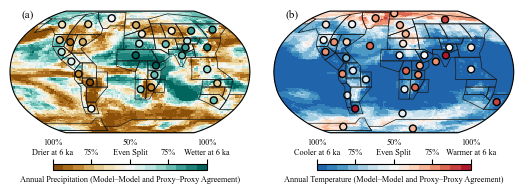

In [7]:
#Plot the figure 7
warnings.filterwarnings('ignore')
plt.figure(figsize=(figSize[0],figSize[1]))
if orient == 'v': gs = gridspec.GridSpec(len(variables),1,hspace=0.1,wspace=0.1)
else:             gs = gridspec.GridSpec(1,len(variables),hspace=0.1,wspace=0.1)
for var in variables:
    #Position figure
    i  = [j for j,x in enumerate(variables) if x == var][0]
    if orient == 'v': ax = plt.subplot(gs[i:(i+1),0:1],projection=ccrs.Robinson())
    else:             ax = plt.subplot(gs[0:1,i:(i+1)],projection=ccrs.Robinson())
    #Set figure colors/labels based on climate Variable 
    if var == 'tas': cramp, units, varname, n = 'RdBu_r','degC', 'Temperature', ['Cooler at 6 ka','Warmer at 6 ka']
    else:            cramp, units, varname, n = 'BrBG', 'mm/day', 'Precipitation', ['Drier at 6 ka','Wetter at 6 ka',]
    #Color bins based on model dimension
    cramp = cmr.get_sub_cmap(cramp,0.1,0.9,N=modelN+1)
    #Set up map
    ax.annotate('('+list(map(chr, range(97, 123)))[i]+')',xy=(0, 0), xycoords='data', xytext=(0.05, 0.95), textcoords='axes fraction', fontsize=8, fontfamily = 'Times New Roman')
    refRegLand.plot_regions(ax=ax,add_label=False,line_kws=dict(linewidth=0.5))
    #Plot data
    model_agree = plt.pcolormesh(modelVals[szn][var]['modelSign%'].lon, modelVals[szn][var]['modelSign%'].lat, modelVals[szn][var]['modelSign%'], 
                                 cmap=cramp, vmin=-100, vmax=100, transform=ccrs.PlateCarree(),alpha=1)
    ax.scatter(proxyData[var].lon, proxyData[var].lat, c=proxyData[var].proxyPct,
               cmap=cramp, s=25 ,ec='k', lw=1, vmin=0, vmax=100, transform=ccrs.PlateCarree())
    #ax.scatter(proxy.longitude, proxy.latitude, s=5 ,ec='red',alpha=1, lw=1, transform=ccrs.PlateCarree())
    #ax.coastlines()
    #Color bar
    if orient == 'v': 
        cbar = plt.colorbar(model_agree,orientation="horizontal",ticks=range(-100,101,50), fraction=0.04, pad=0.15,aspect=25)
        cbar.ax.set_xticklabels(['100%\n'+n[0],'75%','50%\nEven Split','75%','100%\n'+n[1]], fontsize=6, verticalalignment='baseline')
        cbar.ax.xaxis.set_ticks_position("top")    
        cbar.ax.text(0,-400,'Annual '+varname+' (Model–Model and Proxy–Proxy Agreemen)', horizontalalignment='center', verticalalignment='center',fontsize=6)
    else: 
        cbar = plt.colorbar(model_agree,orientation="horizontal",ticks=range(-100,101,50), fraction=0.02, pad=0.1,aspect=25)
        cbar.ax.set_xticklabels(['100%\n'+n[0],'75%','50%\nEven Split','75%','100%\n'+n[1]], fontsize=6, verticalalignment='baseline')
        cbar.ax.xaxis.set_ticks_position("top")    
        cbar.ax.text(0,-400,'Annual '+varname+' (Model–Model and Proxy–Proxy Agreement)', horizontalalignment='center', verticalalignment='center',fontsize=6)
    
#Save/Plot
filename = 'Fig8_midHoloceneAgreement_'
for var in variables: filename=filename+var+'_'
if save: plt.savefig('Figures/Model/'+filename+szn+'.png', dpi=600,format='png', bbox_inches='tight')       
plt.show()


In [8]:
#Calculate % warm/cool 6 ka anomalies based on model mean for entire region
#for var in variables:
#    refReg  = rm.defined_regions.ar6.all
#    weights = np.cos(np.deg2rad(modelVals[szn][var]['modelAnom'].lat))
#    #Land mask
#    mask   = refReg.mask_3D(modelVals[szn][var]['modelAnom'].lon,modelVals[szn][var]['modelAnom'].lat)  
#    if var != 'tas':
#        land   = rm.defined_regions.natural_earth.land_110
#        land   = land.mask_3D(modelVals[szn][var]['modelAnom'].lon,modelVals[szn][var]['modelAnom'].lat)  
#        land   = np.array([land.squeeze('region').data]*np.shape(refReg)[0])
#        mask = mask*land
#    #
#    vals_regional = modelVals[szn][var]['modelAnom'].weighted(mask * weights).mean(dim=("lat", "lon",))
#    df=pd.DataFrame({'region':vals_regional.abbrevs,
#                     'modelN':np.sum(np.sign(vals_regional),axis=0),
#                     'anom':vals_regional.mean(axis=0)})
#    df['modelPct'] = (100+100*df.modelN/np.max(np.abs(df.modelN)))/2
#    #if var == 'tas':
        #print('Number of regions showing consensus for warm 6 ka anomaly')
        #print(str(round(100*52/58)),'%')
        #print(df)#.sort_values('modelPct',ascending=False))#.head(n=5))
#    proxyData[var]=proxyData[var].merge(df, left_on='region', right_on='region')

Precipitation (19/30 agree; 2/30 disagree)
Temperature (9/35 agree; 18/35 disagree)


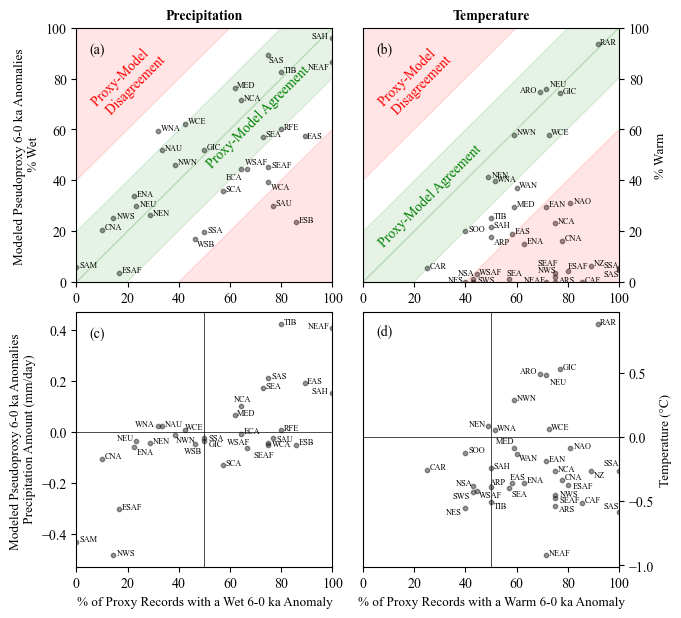

In [9]:
#Plot the figure 8
import matplotlib.patches as patches
import matplotlib.lines as lines

#Plot Settings
font='times new roman'
fontsize=9.5
fig = plt.figure(figsize=(7, 7))

#These should be opposite otherwise plotting same thing on each axis
pseudo_x=False #False = compare proxies to models. Otherwise test models
pseudo_y=True  #True  = Use greographic bias of proxy locations?

for var in ['pre','tas']:
    #Set figure labels/positions for plotting
    if var == 'tas': 
        varName='Temperature'
        cramp='RdBu_r'
        ax1 = fig.add_subplot(222)
        ax1.set_ylabel("% Warm",size=fontsize)
        #ax1.set_xlabel("% of proxy records with a warm mid-Holocene anomaly",size=fontsize)
        ax2 = fig.add_subplot(224)
        ax2.set_ylabel("Temperature ("+u'\N{DEGREE SIGN}'+"C)",size=fontsize) ###
        ax2.set_xlabel("% of Proxy Records with a Warm 6-0 ka Anomaly",size=fontsize) ###
        #
        ax1.yaxis.tick_right()
        ax2.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")
        ax2.yaxis.set_label_position("right")
    else: 
        varName='Precipitation'
        cramp='BrBG'
        ax1 = fig.add_subplot(221)
        ax1.set_ylabel("Modeled Pseudoproxy 6-0 ka Anomalies \n % Wet",size=fontsize)
        #ax1.set_xlabel("% of proxy records with a wet mid-Holocene anomaly",size=fontsize)
        ax2 = fig.add_subplot(223)
        ax2.set_ylabel("Modeled Pseudoproxy 6-0 ka Anomalies \n Precipitation Amount (mm/day)",size=fontsize)  ###
        ax2.set_xlabel("% of Proxy Records with a Wet 6-0 ka Anomaly",size=fontsize) ###
    ax1.set_title(varName,size=10,weight='bold')
    #
    ### Top Row ------------------------------------------
    #Add gridlines to aid visual
    ax1.add_patch(patches.Rectangle((-20, -20), -14, 1000,color='green',alpha=0.1,angle=315))
    ax1.add_patch(patches.Rectangle((-20, -20), 14, 1000,color='green',alpha=0.1,angle=315))
    ax1.add_patch(patches.Rectangle((0, 40), -60, 1000,color='red',alpha=0.1,angle=315))
    ax1.add_patch(patches.Rectangle((40, 0), 60, 1000,color='red',alpha=0.1,angle=315))
    #Set figure bound
    ax1.set_xlim([0, 100])
    ax1.set_ylim([0, 100])
    #Data to plot
    x1 = proxyData[var].proxyPct
    y1 = proxyData[var].PseudoProxyPct
    text1 = proxyData[var].region
    #Plot Scatter
    ax1.scatter(x1, y1, c='k', alpha=0.4,s=10,vmin=0, vmax=100)
    #Loop for annotation of all points
    for i in range(len(x1)):
        xnudge = 1
        ynudge = 0
        if var != 'tas':
            if text1[i] == 'WSB': ynudge=-3
            elif text1[i] == 'EAS': ynudge=-1
            elif text1[i] == 'NEAF': xnudge,ynudge =-10,-3
            elif text1[i] == 'WSAF': ynudge,xnudge=2,-1
            elif text1[i] == 'SAH': xnudge=-8
            elif text1[i] == 'ECA': xnudge,ynudge= -6,-4
            elif text1[i] == 'ECA': ynudge= -3
            #elif text1[i] == 'NWS': xnudge=-9
            elif text1[i] == 'WCA': ynudge= -3
            elif text1[i] == 'SAS': xnudge,ynudge =0,-3
        else: 
            if text1[i] == 'ARO': xnudge=-8
            elif text1[i] == 'ARP': ynudge=-3
            elif text1[i] == 'NEU': ynudge=1
            elif text1[i] == 'SSA': xnudge,ynudge=-6,1
            elif text1[i] == 'SAS': xnudge,ynudge=-6,-3
            elif text1[i] == 'SAS': xnudge,ynudge=-6,-3
            elif text1[i] == 'NSA': xnudge,ynudge=-6,1.5
            elif text1[i] == 'NES': xnudge,ynudge=-7,0
            elif text1[i] == 'SEAF': xnudge,ynudge=-7,3
            elif text1[i] == 'NEAF': xnudge,ynudge=-9,0
            elif text1[i] == 'ARS': xnudge,ynudge=1.5,0
            elif text1[i] == 'NWS': xnudge,ynudge=-7,2
            elif text1[i] == 'SEA': ynudge,xnudge= 1.5,-1
            elif text1[i] == 'SWS': ynudge,xnudge= 0,2
            elif text1[i] == 'ESAF': ynudge,xnudge= 1,0
        ax1.annotate(text1[i], (x1[i]+xnudge, y1[i]+ynudge), size=6)
    #
    ### Bottom Row ------------------------------------------
    #Data to plot
    x2 = x1
    y2 = proxyData[var].PseudoProxyAvg
    text2 = proxyData[var].region
    #Add gridlines to aid visual
    ax2.axhline(y = 0,color='k',lw=0.5)
    ax2.axvline(x = 50,color='k',lw=0.5)
    #Set figure bound
    ax2.set_xlim([0, 100])
    if var == 'tas':  ax2.set_yticks([-1,-0.5,0,0.5])
    #else:  #ax2.set_ylim([-0.4, 0.8])
    #Plot Scatter
    scatter = ax2.scatter(x2, y2, c='k', s=10, alpha=0.4,vmin=0, vmax=100)
    #Loop for annotation of all points
    for i in range(len(x2)):
        xnudge = 1
        ynudge = 0
        if var != 'tas':
            if text2[i] == 'WSB': ynudge,xnudge= -0.04,-4
            elif text2[i] == 'WNA': ynudge,xnudge=-0.0,-9
            elif text2[i] == 'NEU': xnudge=-8
            elif text2[i] == 'NEAF': xnudge=-10
            elif text2[i] == 'SAH': xnudge=-8
            #elif text2[i] == 'SAS': ynudge=-0.05
            elif text2[i] == 'ENA': ynudge,xnudge= -0.03,1
            elif text2[i] == 'NWN': ynudge,xnudge= -0.03,0
            #elif text2[i] == 'RFE': ynudge,xnudge= 0.02,-0
            #elif text2[i] == 'ECA': ynudge,xnudge= 0.02,-0
            elif text2[i] == 'SAU': ynudge,xnudge= -0.01,1.4
            elif text2[i] == 'WCA': ynudge,xnudge= -0.014,1.5
            elif text2[i] == 'NCA': ynudge,xnudge= 0.02,-3
            elif text2[i] == 'WCE': ynudge,xnudge= 0,0#-0.02,-2
            #elif text2[i] == 'SCA': ynudge,xnudge= 0.01,-7
            elif text2[i] == 'SSA': ynudge,xnudge= 0.005,1.5#-0.03,-12
            elif text2[i] == 'GIC': ynudge,xnudge= -0.035,1.5#-0.03,-12
            elif text2[i] == 'WSAF': ynudge,xnudge= 0.015,-8
            elif text2[i] == 'SEAF': ynudge,xnudge= -0.05,-6
        else:
            if text2[i] == 'ARO': ynudge,xnudge= 0,-8
            elif text2[i] == 'NZ': ynudge,xnudge= -0.05,1
            elif text2[i] == 'NEU': ynudge,xnudge= -0.07,1
            elif text2[i] == 'NEN': ynudge,xnudge= 0,-8
            elif text2[i] == 'MED': ynudge,xnudge= 0.03,-7
            elif text2[i] == 'WAN': ynudge,xnudge= -0.05,1
            elif text2[i] == 'NWS': ynudge,xnudge= -0.01,1.6
            elif text2[i] == 'SEAF': ynudge,xnudge= -0.03,1.6
            elif text2[i] == 'ARS': ynudge,xnudge= -0.04,1.6
            #elif text2[i] == 'NCA': ynudge,xnudge= 0.03,-7
            elif text2[i] == 'SSA': ynudge,xnudge= 0.04,-6
            elif text2[i] == 'SAS': ynudge,xnudge= 0.03,-6
            elif text2[i] == 'WSAF': ynudge,xnudge= -0.05,1
            elif text2[i] == 'SWS': ynudge,xnudge=  -0.05,-8
            elif text2[i] == 'NES': ynudge,xnudge= -0.05,-8
            elif text2[i] == 'NSA': ynudge,xnudge= 0.01,-7
            elif text2[i] == 'TIB': ynudge,xnudge= -0.05,1
            elif text2[i] == 'SEA': ynudge,xnudge= -0.07,1
            elif text2[i] == 'EAS': ynudge,xnudge= 0.03,-1
            elif text2[i] == 'ARP': ynudge,xnudge= 0.02,-0.5
            elif text2[i] == 'ESAF': ynudge,xnudge= -0.03,2
        ax2.annotate(text2[i], (x2[i]+xnudge, y2[i]+ynudge), size=6)
    #
    # Summarize data shown in the top row ------------------------------------------
    agreeN =  sum(abs(proxyData[var]['proxyPct']-proxyData[var]['PseudoProxyPct']) < 20)
    disagreeN = sum(abs(proxyData[var]['proxyPct']-proxyData[var]['PseudoProxyPct']) >40)
    totalN=len(proxyData[var])
    print(varName+" ("+str(agreeN)+"/"+str(totalN)+" agree; "+str(disagreeN)+"/"+str(totalN)+" disagree)")
    #Label
    if var == 'tas':
        ax1.annotate('Proxy-Model Agreement', (5, 14),color='green',size=10,rotation=45)
        ax1.annotate('(b)', (5, 90),color='k',size=10)
        ax2.annotate('(d)', (5, 0.8),color='k',size=10)
    else:
        ax1.annotate('Proxy-Model Agreement', (50, 45),color='green',size=10,rotation=45)
        ax1.annotate('(a)', (5, 90),color='k',size=10)
        ax2.annotate('(c)', (5, 0.37),color='k',size=10)
    ax1.annotate('Proxy-Model \n Disagreement', (5, 65),color='red',size=10,rotation=45)
    #
plt.subplots_adjust(wspace=0.12, hspace=0.12)
plt.savefig('Figures/Model/Figure9_AgreeScatter.png', dpi=600,format='png', bbox_inches='tight')  
plt.show()


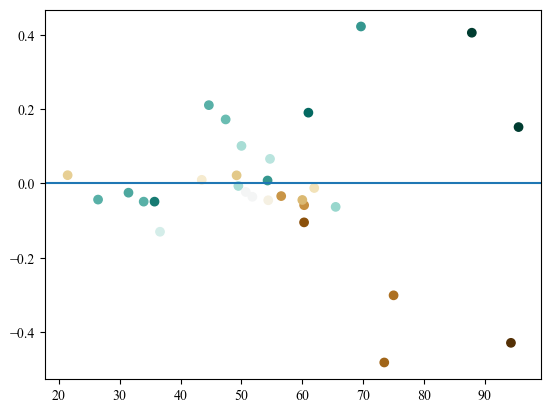

In [10]:
#Visualize panel C above if we ignore directionality of wet/dry (still shown by color)
var='pre' 
plt.scatter(proxyData[var]['agreeByLoc'],proxyData[var]['PseudoProxyAvg'],
            c=proxyData[var]['proxyPct'],cmap='BrBG',vmin=0,vmax=100)
plt.axhline(0)

In [11]:
thresh=40
proxyData['pre']
print('add these numbers to get n of proxy-model agreement which is not "in the middle of the graph"')
print(str(sum(np.array(proxyData['pre']['proxyPct']<thresh)&np.array(proxyData['pre']['PseudoProxyPct']<thresh)))+'+'+str(sum(np.array(proxyData['pre']['proxyPct']>100-thresh)&np.array(proxyData['pre']['PseudoProxyPct']>100-thresh))))
      
print('number of regions with proxy proxy warm agreement:')
print(sum(np.array(proxyData['tas']['proxyPct']>100-thresh)))      

print('number of regions with proxy proxy cold agreement:')
print(sum(np.array(proxyData['tas']['proxyPct']<thresh)))      

print('number of regions with pseduoproxy pseduoproxy warm agreement:')
print(sum(np.array(proxyData['tas']['PseudoProxyPct']>100-thresh)))      

print('number of regions with pseduoproxy pseduoproxy cold agreement:')
print(sum(np.array(proxyData['tas']['PseudoProxyPct']<thresh)))     
          
      

add these numbers to get n of proxy-model agreement which is not "in the middle of the graph"
7+6
number of regions with proxy proxy warm agreement:
19
number of regions with proxy proxy cold agreement:
1
number of regions with pseduoproxy pseduoproxy warm agreement:
4
number of regions with pseduoproxy pseduoproxy cold agreement:
28


In [12]:
proxyData['tas'].loc[abs(proxyData['tas']['proxyPct']-proxyData['tas']['PseudoProxyPct'])<20]

,lat,lon,region,n,proxyPct,PseudoProxyAvg,PseudoProxyPct,agreeByLoc
0,83.131437,1.053556,ARO,13,69.231,0.496491,74.725,64.84
4,18.500000,-72.500000,CAR,4,25.000,-0.253720,5.357,73.21
10,73.891762,-39.946360,GIC,39,76.923,0.529747,74.359,64.84
15,64.448399,-81.895070,NEN,45,48.889,0.088107,41.270,53.02
17,63.214392,11.912721,NEU,95,71.579,0.486774,75.865,65.04
19,63.942315,-132.588290,NWN,39,58.974,0.291953,57.875,50.18
22,71.585596,109.223876,RAR,12,91.667,0.884260,93.452,85.12
32,50.588774,20.742660,WCE,62,72.581,0.063058,57.949,54.49
33,42.376471,-115.735294,WNA,35,51.429,0.057309,39.592,55.51
